# Exercice 2

**Question 1)**: Pour tout vecteur $ z \in \mathbb{R} $, on note $ L(z) $ le vecteur $ (L_1(z), \dots, L_n(z)) $ dont la composante $ L_k(z) $ est définie par 

$L_k(z) = \sum_{i=1}^{k} z(i)$.

Expliquer pourquoi $ L_k(z) $ est la valeur optimale du programme linéaire en variables 0-1 suivant :

$\min \sum_{i=1}^{n} a_{ik} z_i$

sous les contraintes :

$\sum_{i=1}^{n} a_{ik} = k$,

$a_{ik} \in \{0, 1\}, \quad i = 1, \dots, n$.

**Explication**: Étant donné que le vecteur $ (z_{(1)x}, \ldots, z_{(n)x}) $ est ordonné en ordre croissant, la somme $ \sum_{i=1}^{k} z(i) $ correspond à la somme des $ k $ plus petites valeurs de $ z_i $ et donc à la valeur optimale du programme linéaire.



**Question 2)**: 

Primal:

\begin{align*}
\min & \sum_{i=1}^{n} a_{ik} z_i \\
\text{s.c.} \quad & \sum_{i=1}^{n} a_{ik} = k \\
& 0 \leq a_{ik} \leq 1, \quad i = 1, \dots, n
\end{align*}

Dual:

\begin{align*}
\max & \quad k \cdot r_k - \sum_{i=1}^{n} b_{ik} \\
\text{s.c.} \quad & r_k - b_{ik} \leq z_i, \quad \forall i = 1, \dots, n \\
& b_{ik} \geq 0, \quad \forall i = 1, \dots, n
\end{align*}

$r_k$ -> k plus petit élément de $z$

Trouver $L(2,9,6,8,5,4)$:

In [22]:
from gurobipy import *
import numpy as np
import  matplotlib.pyplot as plt


In [23]:
z = [2,9,6,8,5,4]
n = len(z)
sum(z)

34

In [24]:
for k in range(1,n+1):
    model = Model()
    model.params.LogToConsole = False

    rk = model.addVar(vtype=GRB.CONTINUOUS, name='rk')
    bki = model.addVars(n,vtype=GRB.CONTINUOUS,name=f'bi{k}')

    model.setObjective((k) * rk - quicksum(bki), GRB.MAXIMIZE)

    model.addConstrs(((rk-bki[i])<=z[i] for i in range(n)), name='c1')
    model.addConstrs((bki[i]>=0 for i in range(n)), name='c2')

    model.optimize()
    composante = int(model.objVal)
    print(f"L_{k}(z) = {composante}")
   # print(rk)
    #print(bki)
   # print("-------------")



L_1(z) = 2
L_2(z) = 6
L_3(z) = 11
L_4(z) = 17
L_5(z) = 25
L_6(z) = 34


/tmp/ipykernel_5536/3516057902.py:8: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.setObjective((k) * rk - quicksum(bki), GRB.MAXIMIZE)


**Question 3:** Montrer que 
\begin{align*}
g(x)& =\sum_{i=1}^{n}w_iz_{(i)}(x)\\
&=\sum_{k=1}^{n}w'_k L_k(z(x))
\end{align*}
**Explication:** 

\begin{align*}
\text{par définition: }z_{(k)}(x)&=L_k(z(x)) - L_{k-1}(z(x))\\
g(x)& =\sum_{i=1}^{n}w_iz_{(i)}(x)\\
&=w_1z_{(1)}+w_2z_{(2)}+\ldots+w_nz_{(n)}\\
&=w_1L_1(z(x))+w_2(L_2(z(x))-L_1(z(x)))+\ldots+w_n(L_n(z(x))-L_{n-1}(z(x))\\
&=(w_1-w_2)L_1(z(x))+(w_2-w_3)(L_2(z(x)))+\ldots+(w_{n-1}-w_{n})L_n\\
&=\sum^n_{k=1}w'_kL_k(z(x))
\end{align*}

**Question 4:**
\begin{align*}
\max &\sum_{k=1}^n w'_k \left( k \cdot r_k - \sum_{i=1}^n b_{ik} \right) \\
\text{s.c.} & \quad r_k - b_{ik} \leq z_i(x), \quad i = 1, \dots, n \\
& \quad b_{ik} \geq 0, \quad i = 1, \dots, n \\
& \quad x \in X
\end{align*}

$x \in X$ -> solution réalisables 

In [25]:
def maxOWA(C_max,valeurs_scenarios, couts, w=[2,1]):

    model = Model()
    model.params.LogToConsole = False

    n_projets = len(valeurs_scenarios[0])
    n_scenarios = len(valeurs_scenarios)

    print(valeurs_scenarios)
    x = model.addVars(n_projets,vtype=GRB.BINARY,name='x')
    z = []
    for i in range(n_scenarios):
        z.append(quicksum([valeurs_scenarios[i][j]*x[j] for j in range(n_projets)]))

    w = [i+1 for i in range(n_scenarios)][::-1]    
    w_apostrophe = [w[k] - w[k+1] for k in range(len(w)-1)]
    w_apostrophe.append(w[-1])
    print(w_apostrophe)
    rk = model.addVars(n_scenarios,vtype=GRB.CONTINUOUS, name='rk')
    bik = []
    
    for k in range(n_scenarios):
        bik.append(model.addVars(n_scenarios,vtype=GRB.CONTINUOUS, lb=0,name=f'bik {k}'))
    objectif = quicksum([w_apostrophe[k]*((k+1)*rk[k]-quicksum([bik[k][i] for i in range(n_scenarios)])) for k in range(n_scenarios)])
    
    model.setObjective(objectif, GRB.MAXIMIZE)
    
    for k in range(n_scenarios):
        for i in range(n_scenarios):
            model.addConstr(rk[k]-bik[k][i]<=z[i]) # premiere contrainte

    model.addConstr(quicksum(couts[j] * x[j] for j in range(n_projets)) <= C_max, name="ContraineBudget")
    model.optimize()
    #print(model.ObjVal)
    #objets_selectiones = [i for i in range(n_projets) if x[i].X > 0.5]
    #print(objets_selectiones)
    objets_selectiones = [i for i in range(n_projets) if x[i].X > 0.5]
    profit = int(model.objVal)
    vecteur_image_z = []
    for v_s in valeurs_scenarios:
        vecteur_image_z.append(sum([v for i,v in enumerate(v_s) if i in objets_selectiones]))
    objets_selectiones = [o+1 for o in objets_selectiones]
    return {'vecteur_z':vecteur_image_z, 'objets': objets_selectiones, 'profit': profit}



In [26]:
# projets de l'exemple 1
valeurs_scenarios = [[70,18,16,14,12,10,8,6,4,2],
                       [2,4,6,8,10,12,14,16,18,70]]
couts = [60,10,15,20,25,20,5,15,20,60]
C_max = 100
maxOWA(C_max,valeurs_scenarios, couts, w=[2,1])

[[70, 18, 16, 14, 12, 10, 8, 6, 4, 2], [2, 4, 6, 8, 10, 12, 14, 16, 18, 70]]
[1, 1]


{'vecteur_z': [66, 66], 'objets': [2, 3, 4, 7, 8, 9], 'profit': 198}

**Question 5:** trouver un formulation linéaire pour le critère de *minOWA*

**Réponse:** 

Primal:
\begin{align*}
    L_k(z)&=\sum_{i=1}^{k} r(x,s_{(i)}) \text{ regret en ordre décroissant, donc:}\\
    \max &\sum_{i=1}^n a_{ik} r(x,s_{(i)})\\
\text{s.c.} \quad & \sum_{i=1}^{n} a_{ik} = k \\
& 0 \leq a_{ik} \leq 1, \quad i = 1, \dots, n
\end{align*}
$r(x,s_{(i)}) = z_i^*-z_i(x)$

Dual:
\begin{align*}
\min & \quad k \cdot r_k + \sum_{i=1}^{n} b_{ik} \\
\text{s.c.} \quad & r_k + b_{ik} \geq r(x,s_{(i)}), \quad \forall i = 1, \dots, n \\
& b_{ik} \geq 0, \quad \forall i = 1, \dots, n
\end{align*}



In [27]:
z = [2,9,6,8,5,4]
n = len(z)
for k in range(1,n+1):
    model = Model()
    model.params.LogToConsole = False

    rk = model.addVar(vtype=GRB.CONTINUOUS, name='rk')
    bki = model.addVars(n,vtype=GRB.CONTINUOUS,name=f'bi{k}')

    model.setObjective((k) * rk + quicksum(bki), GRB.MINIMIZE)

    model.addConstrs(((rk+bki[i])>=z[i] for i in range(n)), name='c1')
    model.addConstrs((bki[i]>=0 for i in range(n)), name='c2')

    model.optimize()
    composante = int(model.objVal)
    print(f"L_{k}(z) = {composante}")
    #print(rk)
    #print(bki)
    print("-------------")

L_1(z) = 9
-------------
L_2(z) = 17
-------------
L_3(z) = 23
-------------
L_4(z) = 28
-------------
L_5(z) = 32
-------------
L_6(z) = 34
-------------


/tmp/ipykernel_5536/4154286.py:10: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.setObjective((k) * rk + quicksum(bki), GRB.MINIMIZE)


Formulation entière:

\begin{align*}
\min &\sum_{k=1}^n w'_k \left( k \cdot r_k + \sum_{i=1}^n b_{ik} \right) \\
\text{s.c.} & \quad r_k + b_{ik} \geq r(x,s_{(i)}), \quad i = 1, \dots, n \\
& \quad b_{ik} \geq 0, \quad i = 1, \dots, n \\
& \quad x \in X
\end{align*}

In [28]:
# optimiser le probleme sad pour trouver z*
def model_sad_maxmin(c,valeurs_scenarios, p):
    n = len(p)
    model = Model()
    model.params.LogToConsole = False

    t = model.addVar(vtype = GRB.INTEGER)
    x = model.addVars(n, vtype=GRB.BINARY)

    model.setObjective(t, GRB.MAXIMIZE)

    model.addConstr(quicksum(p[i] * x[i] for i in range(n)) <= c) # contraint de poids maximum

    for s_p in valeurs_scenarios:
        model.addConstr(t <= quicksum(s_p[i] * x[i] for i in range(n))) # contraint de valeur minimale pour scénario s

    model.optimize()
    objets_selectiones = [i for i in range(n) if x[i].X > 0.5]
    profit = int(model.objVal)

    vecteur_image_z = []
    for v_s in valeurs_scenarios:
        vecteur_image_z.append(sum([v for i,v in enumerate(v_s) if i in objets_selectiones]))

    return {'vecteur_z':vecteur_image_z, 'objets': objets_selectiones, 'profit': profit}



In [33]:
def minOWA(C_max,valeurs_scenarios, couts,w =[2,1]):

    z_etoile = []
    # calculer z*
    for v_s in valeurs_scenarios:
        gurobi_solution = model_sad_maxmin(c=C_max, valeurs_scenarios=[v_s], p=couts) # model_sad_maxmin avec un scénario est égal à optimiser le problème sad
        z_etoile.append(gurobi_solution['profit'])
    print(z_etoile)
    model = Model()
    model.params.LogToConsole = False

    n_projets = len(valeurs_scenarios[0])
    n_scenarios = len(valeurs_scenarios)

    x = model.addVars(n_projets,vtype=GRB.BINARY,name='x')

    w = [i+1 for i in range(n_scenarios)][::-1]

    # calculer le regret r(x,s(i))
    r = []
    for i in range(n_scenarios):
        z = quicksum([valeurs_scenarios[i][j]*x[j] for j in range(n_projets)])
        r.append(z_etoile[i]-z)

    w_apostrophe = [w[k] - w[k+1] for k in range(len(w)-1)]
    w_apostrophe.append(w[-1])
    rk = model.addVars(n_scenarios,vtype=GRB.CONTINUOUS, name='rk')
    bik = []
    for k in range(n_scenarios):
        bik.append(model.addVars(n_scenarios,vtype=GRB.CONTINUOUS, lb=0,name=f'bik {k}'))
#    print(w_apostrophe)

    objectif = quicksum([w_apostrophe[k]*((k+1)*rk[k]+quicksum(bik[k][i] for i in range(n_scenarios))) for k in range(n_scenarios)])
    model.setObjective(objectif, GRB.MINIMIZE)
    for k in range(n_scenarios):
        for i in range(n_scenarios):
            model.addConstr(rk[k]+bik[k][i]>=r[i]) # premiere contrainte
            model.addConstr(bik[k][i]>=0)

    model.addConstr(quicksum(couts[j] * x[j] for j in range(n_projets)) <= C_max, name="BudgetConstraint")
    model.optimize()
    objets_selectiones = [i for i in range(n_projets) if x[i].X > 0.5]
    profit = int(model.objVal)
    vecteur_image_z = []
    for i,v_s in enumerate(valeurs_scenarios):
        vecteur_image_z.append(sum([v for i,v in enumerate(v_s) if i in objets_selectiones]))
    objets_selectiones = [o+1 for o in objets_selectiones]
   
    return {'vecteur_z':vecteur_image_z, 'objets': objets_selectiones, 'profit': profit}

 #   print(model.ObjVal)
  #  objets_selectiones = [i for i in range(n_projets) if x[i].X > 0.5]
  #  print(objets_selectiones)



In [30]:
# projets de l'exemple 1
valeurs_scenarios = [[70,18,16,14,12,10,8,6,4,2],
                       [2,4,6,8,10,12,14,16,18,70]]
couts = [60,10,15,20,25,20,5,15,20,60]
C_max = 100
minOWA(C_max,valeurs_scenarios, couts)

[112, 118]
[[70, 18, 16, 14, 12, 10, 8, 6, 4, 2], [2, 4, 6, 8, 10, 12, 14, 16, 18, 70]]


{'vecteur_z': [62, 70], 'objets': [2, 4, 5, 7, 8, 9], 'profit': 148}

In [31]:

def generate_instances(n_values, p_values, num_instances=1, cost_range=(1, 100), utility_range=(1, 100)):
    instances = []
    for n in n_values:
        for p in p_values:
            for _ in range(num_instances):
                # Générer les coûts des projets
                costs = np.random.randint(cost_range[0], cost_range[1] + 1, size=p)
                
                # Calculer le budget à 50% du coût total des projets
                budget = int(0.5 * np.sum(costs))
                
                # Générer les utilités des projets pour chaque scénario
                utilities = np.random.randint(utility_range[0], utility_range[1] + 1, size=(n, p))
                
                # Enregistrer l'instance avec coûts, utilités et budget
                instance = {
                    'n': n,
                    'p': p,
                    'cout': costs,
                    'budget': budget,
                    'valeurs': utilities
                }
                instances.append(instance)
    return instances

# Exemple d'utilisation
n_values = [5, 10, 15]  # Nombre de scénarios
p_values = [10, 15, 20] # Nombre de projets

instances = generate_instances(n_values, p_values)
len(instances)
instances

#maxOWA(C_max = instances[0]['budget'], valeurs_scenarios=instances[0]['valeurs'], couts=instances[0]['cout'])


[{'n': 5,
  'p': 10,
  'cout': array([16, 42, 19, 67, 97, 46, 22, 48, 77, 69]),
  'budget': 251,
  'valeurs': array([[ 66,  40,  68,  20,  61,  48,   7,   1,  35,  33],
         [ 55,  87,  72,  91,  13,  54,  81,  40,  74,  67],
         [  6,  88,  71,  99,  79, 100,  41,  36,  31,  72],
         [ 62,  81,  92,  34,  15,  61,   8,  48,  72,  76],
         [ 39,  85,  41,  64,  18,  89,  91,  46,  80,  53]])},
 {'n': 5,
  'p': 15,
  'cout': array([69, 44, 19, 70,  2, 19,  7, 84, 93,  9, 73, 93, 52, 94, 66]),
  'budget': 397,
  'valeurs': array([[17, 21,  4, 47, 87, 78, 58, 44, 88, 30, 81, 80, 46, 56, 51],
         [36, 92, 69, 34,  4, 60,  7, 24, 59, 24, 17, 92, 82, 83, 30],
         [69, 51, 27,  8, 56, 69, 39, 80, 60, 89,  8, 13, 85, 95, 42],
         [47, 84, 40, 64, 17, 13, 74, 76, 82, 68, 55, 64, 54, 92, 39],
         [37, 85, 47, 17, 44, 44, 39, 66, 74, 96, 57, 31, 47, 52, 66]])},
 {'n': 5,
  'p': 20,
  'cout': array([14, 80, 40,  8, 86, 23, 70, 26, 30,  7, 97, 54, 99, 81, 87, 

[[48 89 79 49 81 57 18 69 73 93]
 [74 55  6  1 74 82 63 74 68 11]
 [39 34 95 81 99 60 22 91 77 96]
 [33 41 36 75 77 59 25 37 92 33]
 [74 38  4 16 22 42 73 41 41 55]
 [ 1 57 58 76  8 90 10 13 63 94]
 [55 42 72 88 55 11 99 26 69 45]
 [10 83 46 30 60 15 20 26 65 45]
 [17 33 88 85 26 58 67 44 80  2]
 [24 61 14 11 10  3 12 89 42 68]
 [ 5 22 93  8 62 79 76  5 80 67]
 [59 74 56 67 58 41 51 55 53 28]
 [81 19 75  1 36 16 30 80 52 39]
 [18 97 26 46 32 46 52 59 62 32]
 [78 86 80 97  9 46 93  5 25 85]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[ 82  84  18  14 100  22  97  95  98  62]
 [ 28  18  16   2  69  35  79  23  77  98]
 [ 16  63  93  84  97  56  66  42  47  81]
 [ 24  50  45  68  54  22  68  84  13  41]
 [ 92  96  65  38  65  58  87  50  64  41]
 [ 18  42  39  24  95  24  78   4  25  52]
 [ 34  72  31  70  95  93  15  14  14  38]
 [ 78  74  60 100  32  16  10  54  99  60]
 [ 99  49  15  73  64  39  94   7   5  15]
 [ 63  98 100  66  26   7  49  33  98  41]
 [ 70  46  65  70  97  56  7

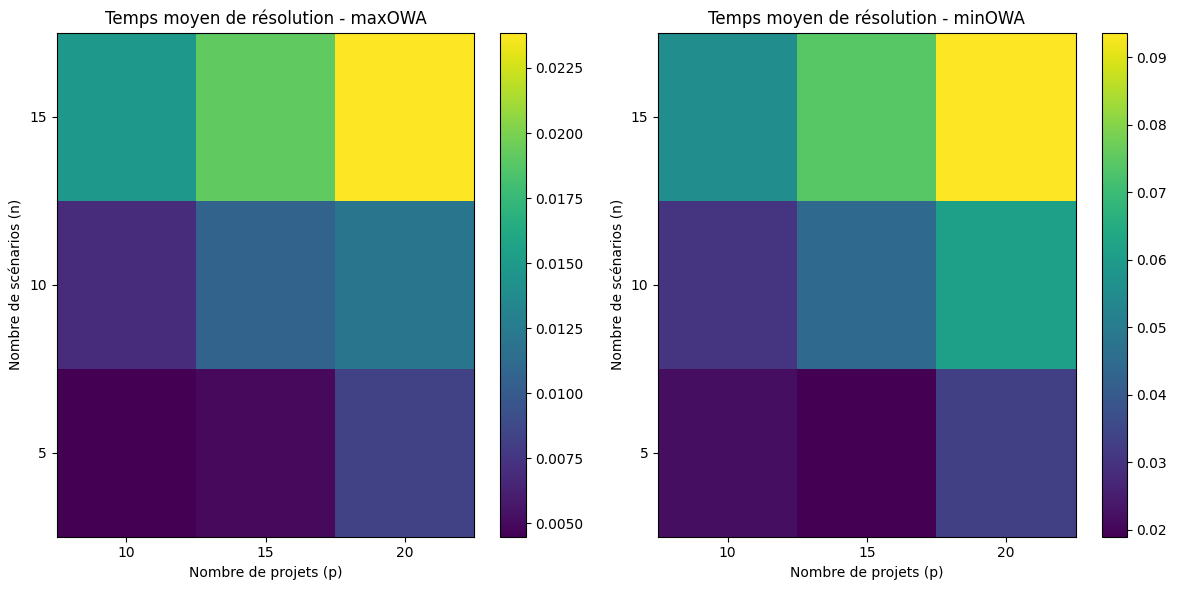

In [34]:
import time


def average_resolution_time(model_function, instances):
    """Calcule le temps moyen de résolution pour un ensemble d'instances donné avec un modèle spécifique."""
    total_time = 0
    for instance in instances:
        start_time = time.time()
        
        # Appeler la fonction modèle pour résoudre l'instance
        model_function(C_max = instance['budget'], valeurs_scenarios=instance['valeurs'], couts=instance['cout'])
        
        end_time = time.time()
        total_time += (end_time - start_time)
    
    # Calculer le temps moyen pour les 10 instances
    avg_time = total_time / len(instances)
    return avg_time

def main(n_values, p_values, num_instances=10):
    
    maxmin_times = np.zeros((len(n_values), len(p_values)))
    regret_times = np.zeros((len(n_values), len(p_values)))
    
    for i, n in enumerate(n_values):
        for j, p in enumerate(p_values):
            # Générer 10 instances pour le couple (n, p)
            instances = generate_instances([n], [p], num_instances=num_instances)
            
            # Calculer le temps moyen pour le modèle maxmin
            avg_time_maxmin = average_resolution_time(maxOWA, instances)
            maxmin_times[i, j] = avg_time_maxmin
            
            # Calculer le temps moyen pour le modèle regret
            avg_time_regret = average_resolution_time(minOWA, instances)
            regret_times[i, j] = avg_time_regret
            
            print(f"(n={n}, p={p}) - Temps moyen maxOWA: {avg_time_maxmin:.4f} s, Temps moyen minOWA: {avg_time_regret:.4f} s")
    
    return maxmin_times, regret_times, n_values, p_values

def plot_results(maxmin_times, regret_times, n_values, p_values):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Heatmap pour le modèle maxmin
    im1 = axs[0].imshow(maxmin_times, cmap='viridis', aspect='auto')
    axs[0].set_title("Temps moyen de résolution - maxOWA")
    axs[0].set_xlabel("Nombre de projets (p)")
    axs[0].set_ylabel("Nombre de scénarios (n)")
    axs[0].set_xticks(np.arange(len(p_values)))
    axs[0].set_yticks(np.arange(len(n_values)))
    axs[0].set_xticklabels(p_values)
    axs[0].set_yticklabels(n_values)
    fig.colorbar(im1, ax=axs[0], orientation='vertical')
    
    # Heatmap pour le modèle regret
    im2 = axs[1].imshow(regret_times, cmap='viridis', aspect='auto')
    axs[1].set_title("Temps moyen de résolution - minOWA")
    axs[1].set_xlabel("Nombre de projets (p)")
    axs[1].set_ylabel("Nombre de scénarios (n)")
    axs[1].set_xticks(np.arange(len(p_values)))
    axs[1].set_yticks(np.arange(len(n_values)))
    axs[1].set_xticklabels(p_values)
    axs[1].set_yticklabels(n_values)
    fig.colorbar(im2, ax=axs[1], orientation='vertical')
    
    plt.tight_layout()
    plt.show()

# Paramètres d'entrée
n_values = [15, 10, 5]  # Nombre de scénarios
p_values = [10, 15, 20] # Nombre de projets

# Lancer l'évaluation du temps moyen de résolution
maxmin_times, regret_times, n_values, p_values = main(n_values, p_values)

# Afficher les résultats avec matplotlib
plot_results(maxmin_times, regret_times, n_values, p_values)
